# The frequency-Hough transform tutorial
### Searching for continuous gravitational waves from isolated, asymmetricly rotating neutron stars
Andrew L. Miller

National Institute for Subatomic Physics / Utrecht University

Searches for continuous waves from isolated, deformed neutron stars are broadly classified into three forms, depending on how much we know about the source: targeted (known position, rotational frequency and spin-down), directed (known position, unknown frequency/spin-down) and all-sky (all parameters unknown).

There are benefits and drawbacks to each kind of search -- see arXiv:2206.06447 for a recent review.

This tutorial will focus on a particular algorithm for all-sky searches for continuous gravitational waves: the frequency-Hough transform. This method maps points in the time/frequency plane of the detector to lines in the frequency/spin-down plane of the source. See arXiv:1407.8333 for more details.

Note: The frequency-Hough transform algorithm and its implementation for CW searches has been designed and implemented for real searches by the Virgo Rome group of the LVK collaboration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrew-l-miller/pyhough/blob/main/tutorials/hough_tutorial.ipynb)

# Import stuff

In [ ]:
# this will take a few minutes on first run, then should use cached files and be fast
!pip install pyhough
!pip install pyfstat

In [ ]:
import os
import pyfstat
import numpy as np
import pyhough
from pyhough import pm
from pyhough import hm
#### for some reason pm and hm need to be imported separately
# make sure to put these after the pyfstat import, to not break notebook inline plots
import matplotlib.pyplot as plt
%matplotlib inline


# Simulate a CW signal and compute a spectrogram

Compute the spectrogram of a set of SFTs. This is useful to produce
visualizations of the Doppler modulation of a CW signal.


In [ ]:
# general setup
label = "PyFstatExampleSpectrogram"
outdir = os.path.join("PyFstat_example_data", label)
logger = pyfstat.set_up_logger(label=label, outdir=outdir)

In [ ]:
# properties of the GW data
depth = 5 ## this is a measure of strength of the GW signal. Larger depth --> smaller GW amplitude

data_parameters = {
    "sqrtSX": 1e-23,
    "tstart": 1000000000,
    "duration": 0.4 * 365 * 86400,
    "detectors": "H1",
    "Tsft": 1800,
}

signal_parameters = {
    "F0": 100.0,
    "F1": -1e-9,
    "F2": 0,
    "Alpha": np.pi/2,
    "Delta": 0.0,
#     "tp": 0,#data_parameters["tstart"],
#     "asini": 0,#25.0,
#     "period": 0,#50 * 86400,
    "tref": data_parameters["tstart"],
    "h0": data_parameters["sqrtSX"] / depth,
    "cosi": 1.0,
}

In [ ]:
# making data
data = pyfstat.Writer(
    label=label, outdir=outdir, **data_parameters, **signal_parameters
)
data.make_data()

In [ ]:
logger.info("Loading SFT data and computing normalized power...")
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(data.sftfilepath)
sft_power = sft_data["H1"].real ** 2 + sft_data["H1"].imag ** 2
normalized_power = (
    2 * sft_power / (data_parameters["Tsft"] * data_parameters["sqrtSX"] ** 2)
)

# Plot spectrogram

Here, we can make out two modulations. One is due to the instrinsic spin-down of the source, and the other is due to the relative motion of the earth around the sun w.r.t. the source.

In equations, the frequency evolution of the signal can be described as:

\begin{equation}
f(t) = \left(f_0+\dot{f}(t-t_0)\right)\left(1+\frac{\vec{v}\cdot\hat{n}}{c}\right) \tag{1}
\end{equation}
where $f_0$ is the emitted GW frequency at the time $t_0$, $\vec{v}$ is the velocity of the detector, $\hat{n}$ is the unit vector between the earth and the source.

$f(t)$ is the measured frequency at time $t$, and is what is plotted in the time/freuqency maps below.

We are interested in obtaining the source parameters, that is, the GW frequency $f_0$ and the spin-down $\dot{f}$.



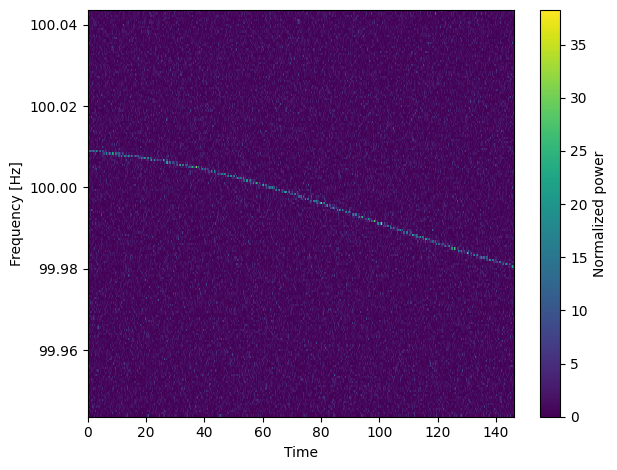

In [ ]:
plt.pcolormesh((times["H1"]-times["H1"][0])/86400, freqs, normalized_power, shading="auto")
plt.xlabel("Time")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Normalized power")
plt.tight_layout()

# Create peakmap from spectrogram

Here, we take the spectrogram computed in PyFstat, and, in each Fast Fourier Transform (that is, at each time in the spectrogram), select local maxima above a chosen threshold. The local maxima criteria reduce the impact of noise lines that may pollute multiple adjacent frequency bins.

We call the resulting thresholded spectrogram a "peakmap", where each surviving time/frequency pixel is called a "peak".

#### Setting threshold on peak selection to be:

In [ ]:
threshold = 3 # need to apply a threshold on equalized power and select maxima above this threshold to run Hough
pm_times,pm_freqs,pm_pows,index = pyhough.pm.make_peakmap_from_spectrogram(times["H1"],freqs,normalized_power,threshold)

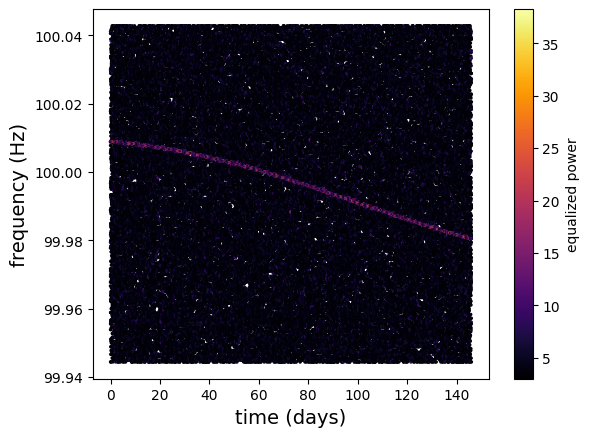

In [ ]:
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,pm_freqs,pm_pows,'.',label='equalized power')
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);
# plt.ylim([99.98,100.02])

# Create source position vector and get detector velocities for Dopp Corr

In [ ]:
# source position and detector velocities
position = [signal_parameters["Alpha"], signal_parameters["Delta"]]
vec_n = pyhough.pm.astro2rect(position,1)
ts,vs = pyhough.pm.get_detector_velocities(data)
Nts = len(ts)

# Remove Doppler shift from peakmap

To search for a continuous wave coming from a particular sky location, we "point" our detector by correcting the data for the Doppler shift induced by the relative motion of earth and the source. In this method, the Doppler correction is a shifting of the time/frequency peaks in the peakmap for a given sky location.

Essentially, this corresponds to the following

\begin{equation}
\frac{f(t)}{\left(1+\frac{\vec{v}\cdot\hat{n}}{c}\right)} = f_0 +\dot{f}(t-t_0) \tag{2}
\end{equation}

Now, the new frequency is simply:

\begin{equation}
f_{\rm new}(t) = f_0 + \dot{f}(t-t_0)
\end{equation}

and we can apply the frequency-Hough Transform to search for this modulation.




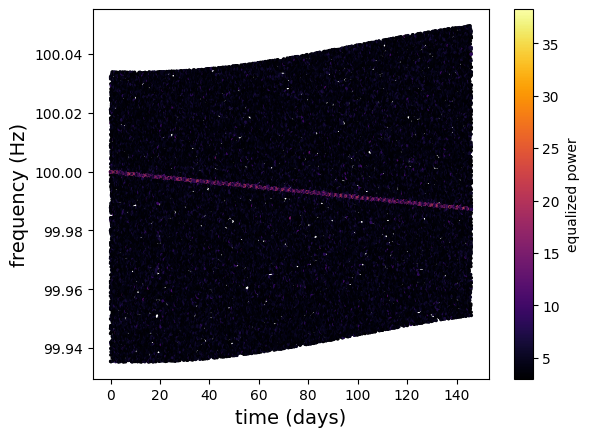

In [ ]:
pm_freqs_undop = pyhough.pm.remove_doppler_from_peakmap(pm_times,pm_freqs,index,vec_n,vs,Nts) # Eq. 2
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,np.array(pm_freqs_undop),pm_pows,'.',label='equalized power')
# plt.ylim([99.989,100.002]);
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);

# Analysis and relevant signal parameters

In [ ]:
alltimes = times["H1"] ### the times of the analysis
Tsft = data_parameters["Tsft"] # the FFT length used
df = 1/Tsft # the frequency bin size
Tobs = data_parameters["duration"] # the duration of the peakmap in seconds
ref_perc_time = 0.5 * 100 # reference time for the Hough at which f0 is determined, set any number between 0 (beginning), 100 (end)
sig_fdot = signal_parameters['F1'] #spin-down of injected signal
dsd = 1/(Tsft*Tobs) # step in spin-down: dsd = df / Tobs
sdgrid = pyhough.hm.make_sd_grid(sig_fdot,dsd) ## grid of spin-downs to search over

# Run frequency-Hough on Doppler corrected peakmap and plot Hough map


The input is the time/frequency peakmap, which is simply a collection of ones. For given choices of $\dot{f}$, we solve for $f_0$

\begin{equation}
f_0 = f_{\rm new}-\dot{f}(t-t_0)
\end{equation}

We thus need to specify a range of $\dot{f}$ values with a particular spacing, given by:

\begin{equation}
\delta\dot{f} = df/T_{\rm obs}
\end{equation}
where $\delta f=1/T_{\rm FFT}$ and $T_{\rm FFT}$ is the FFT length (1800 s in this case), and specify a maximum and minimum $\dot{f}$ to search over.

The Hough sums ones along the time/frequency tracks of the signals, NOT the equalized power on the color axis that is seen in the peakmap plots

The output of this code $\texttt{hmap_from_pm}$ is a 2-dimensional histogram in the $f_0$/$\dot{f}$ plane of the source.

In [ ]:
hmap_from_pm = pyhough.hm.hfdf_hough(pm_times,pm_freqs_undop,Tsft,sdgrid,ref_perc_time)
fs_for_hmap_from_pm = np.arange(np.min(pm_freqs_undop),np.max(pm_freqs_undop),df)


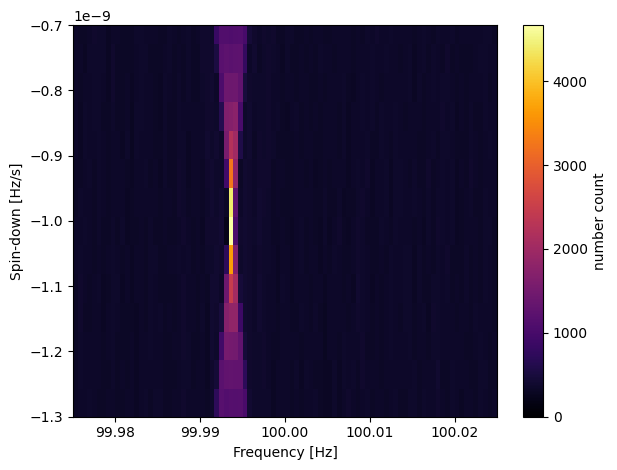

In [ ]:
fig, ax = plt.subplots()#figsize=(0.8 * 16, 0.8 * 9))
ax.set(ylabel="Spin-down [Hz/s]", xlabel=r"Frequency [Hz]")#, ylim=(99.98, 100.02))
c = ax.pcolormesh(
    fs_for_hmap_from_pm,
    sdgrid,
    hmap_from_pm,
    cmap="inferno",
    shading="nearest",
)
fig.colorbar(c, label="number count")
plt.tight_layout()
ax.set(ylim=(sig_fdot*1.3,-0.7e-9));
ax.set(xlim=(99.975,100.025));
# plt.savefig('hm_map.jpg',format='png',dpi=400)

Q1: Why are there seemingly negative slopes of the lines in this map? Can you guess which parameter you need to change to obtain all positive slopes or a mix of positive and negative sloped lines?

Q2: If the true signal frequency and spin-down are  F0 and F1, respectively, why are there multiple pixels in this map surrounding the true values?

# Apply wrong Doppler correction to peakmap, run Hough, and plot

In [ ]:
wrong_position = [np.pi/4, np.pi/5]
wrong_vec_n = pyhough.pm.astro2rect(wrong_position,1)

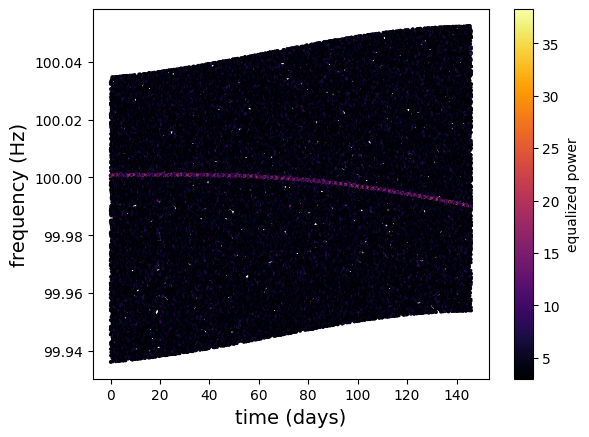

In [ ]:
pm_freqs_undop_wrong = pyhough.pm.remove_doppler_from_peakmap(pm_times,pm_freqs,index,wrong_vec_n,vs,Nts)
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,np.array(pm_freqs_undop_wrong),pm_pows,'.',label='equalized power')
# plt.ylim([99.989,100.002]);
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);

Q3: Do you see the difference between using the wrong and correct source positions to correct the peakmap? What can you conclude about the ability of this method to localize sources in the sky?

Q4: What do you think will happen to a monochromatic noise line after the Doppler correction is applied? Is this good or not? Why?



In [ ]:
# ### run Hough

hmap_wrong_pos = pyhough.hm.hfdf_hough(pm_times,pm_freqs_undop_wrong,Tsft,sdgrid,ref_perc_time)
fs_for_hmap_from_spec_wrong_position = np.arange(np.min(pm_freqs_undop_wrong),np.max(pm_freqs_undop_wrong),df)

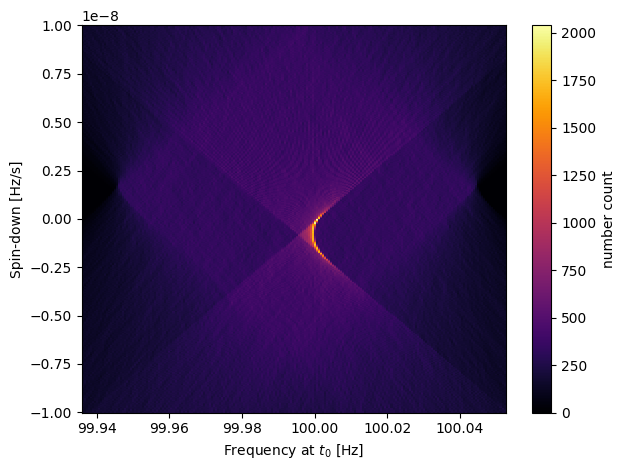

In [ ]:
fig, ax = plt.subplots()#figsize=(0.8 * 16, 0.8 * 9))
ax.set(ylabel="Spin-down [Hz/s]", xlabel=r"Frequency at $t_0$ [Hz]")#, ylim=(99.98, 100.02))
c = ax.pcolormesh(
    fs_for_hmap_from_spec_wrong_position,
    sdgrid,
    hmap_wrong_pos,
    cmap="inferno",
    shading="nearest",
)
fig.colorbar(c, label="number count")
plt.tight_layout()
# ax.set(ylim=(sig_fdot*2,-sig_fdot*1.1));

Q5: Compare the peak number count at the source frequency and spin-down in this Hough map and the one run on the properly corrected peakmap. Why is there a reduction in the number count?



In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
